In [72]:
import os
import torch
from model import GPTConfig, GPT

def load_model(dir):
    ckpt_path = os.path.join(dir, 'ckpt.pt')
    print(f"Loading model from {ckpt_path}...")
    checkpoint = torch.load(ckpt_path)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    return model

In [73]:
out_dir = 'out/shakespeare-char'
model = load_model(out_dir)
print(model.transformer)

Loading model from out/shakespeare-char/ckpt.pt...
number of parameters: 0.80M
ModuleDict(
  (wte): Embedding(65, 128)
  (wpe): Embedding(64, 128)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-3): 4 x Block(
      (ln_1): LayerNorm()
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): MLP(
        (c_fc): Linear(in_features=128, out_features=512, bias=False)
        (gelu): GELU(approximate='none')
        (c_proj): Linear(in_features=512, out_features=128, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm()
)


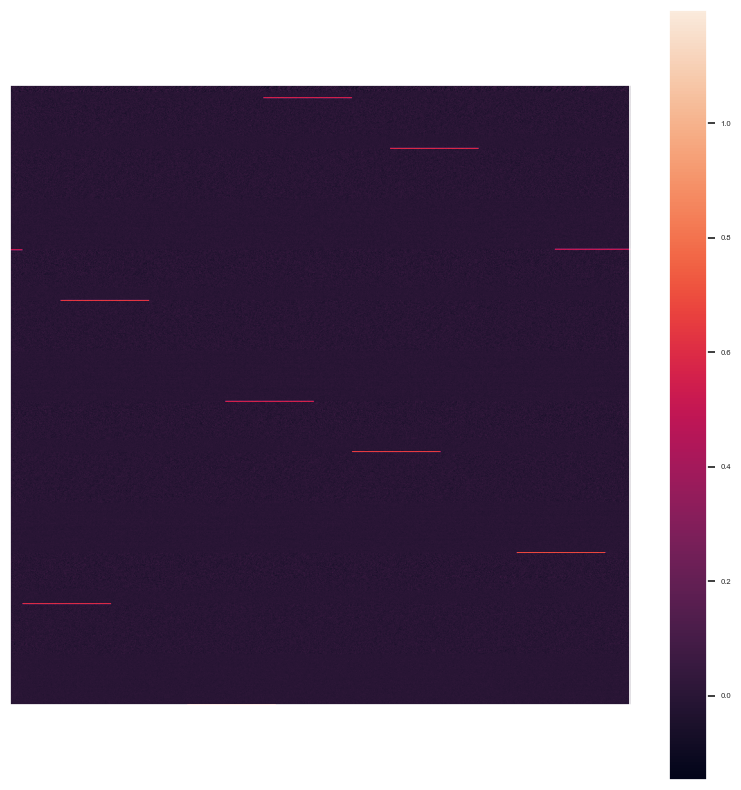

In [74]:
import visualize

visualize.plot_model(model)

In [1]:
# visualize the attention weights
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=0.5)
tmp_attn_weights = {}
tmp_attn_proj_weights = {}
tmp_mlp_weights = {}
tmp_mlp_proj_weights = {}

def visualize_attention(model, text="diff"):
    n_heads = len(model.transformer.h)
    fig, ax = plt.subplots(4, n_heads, figsize=(3*n_heads, 2*3))
    if text is not None:
        fig.suptitle(text)
    for i, h in enumerate(model.transformer.h):
        def plot_weights(tmp_weights, weight, j, i, title):
            tmp_weight = tmp_weights.get(i)
            if tmp_weight != None:
                diff = tmp_weight - weight
                sns.heatmap(
                    diff.detach().cpu().numpy(),
                    ax=ax[j, i],
                    # vmin=-0.25,
                    # vmax=0.25,
                    # cbar=False,
                    xticklabels=False,
                    yticklabels=False,
                    cmap='viridis',
                )
                ax[j, i].set_title(title)
            if tmp_weight == None:
                tmp_weights[i] = torch.clone(weight.detach())
        
        # plot attn weights
        plot_weights(tmp_attn_weights, h.attn.c_attn.weight, 0, i, f"attn_quer l{i}")
        plot_weights(tmp_attn_proj_weights, h.attn.c_proj.weight, 1, i, f"attn_proj l{i}")
        
        # plot mlp weights
        plot_weights(tmp_mlp_weights, h.mlp.c_fc.weight, 2, i, f"mlp_fc l{i}")
        plot_weights(tmp_mlp_proj_weights, h.mlp.c_proj.weight, 3, i, f"mlp_proj l{i}")
            
    plt.tight_layout()
    plt.show()

In [2]:
max_iters = 2000 # total number of training iterations
eval_interval = 100
log_interval = eval_interval

tokens per iteration will be: 768
found vocab_size = 65 (inside data/shakespeare_char/meta.pkl)
Initializing a new model from scratch
number of parameters: 0.80M
num decayed parameter tensors: 17, with 794,752 parameters
num non-decayed parameter tensors: 9, with 1,152 parameters
using fused AdamW: False
step 0: train loss 4.1998, val loss 4.1969


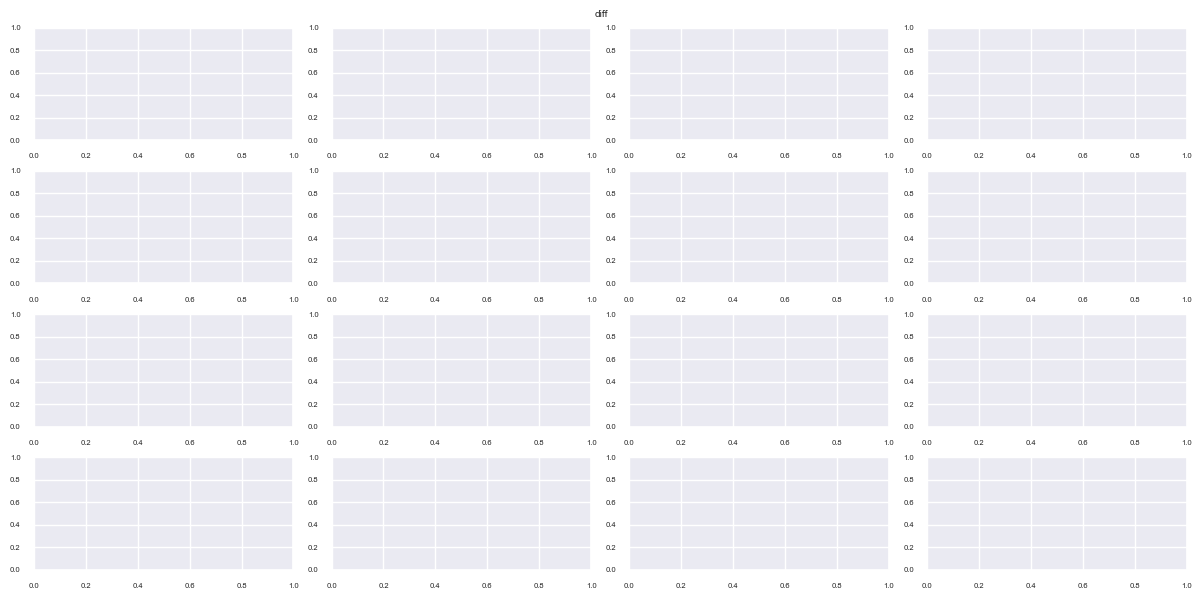

iter 0: loss 4.1949, time 1379.53ms, mfu 0.00%
step 100: train loss 2.4048, val loss 2.3979


KeyboardInterrupt: 

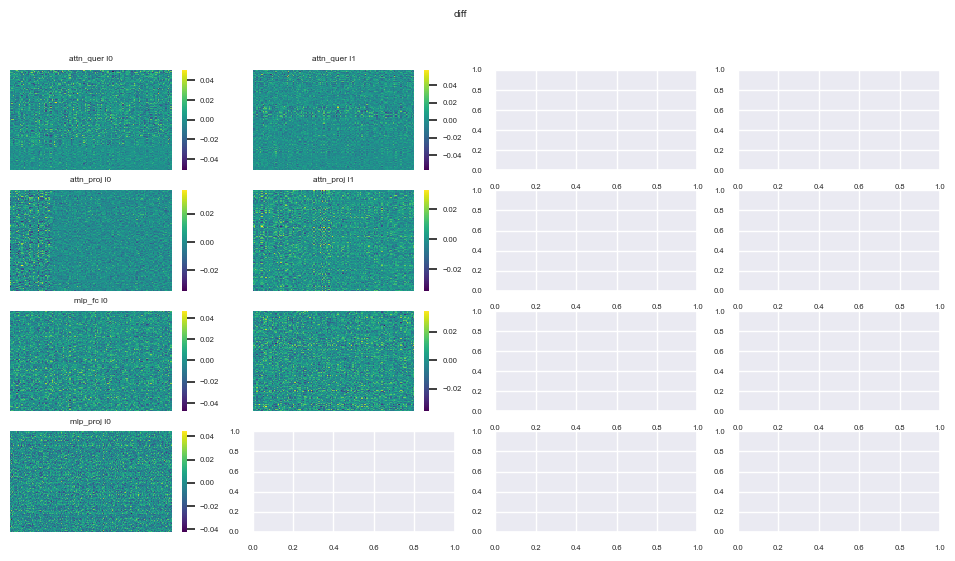

In [4]:
import os
import time
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch

from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
# max_iters = 50 # total number of training iterations
# eval_interval = 100
# log_interval = 100

dir = 'out/shakespeare-char/'
eval_iters = 20
eval_only = False # if True, script exits right after the first eval
save_checkpoint = False
always_save_checkpoint = False # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# data
dataset = 'shakespeare_char'
gradient_accumulation_steps = 1 # used to simulate larger batch sizes
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 64
# model
n_layer = 4
n_head = 4
n_embd = 128
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
pos_encoding = 'alibi' # Positional encoding, see model for supported methods.
# adamw optimizer
learning_rate = 1e-3 # max learning rate
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 0 # how many steps to warm up for
lr_decay_iters = max_iters # should be ~= max_iters per Chinchilla
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# system
device = 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = False # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

# various inits, derived attributes, I/O setup
master_process = True
seed_offset = 0
ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
ctx = nullcontext()

# poor man's data loader
data_dir = os.path.join('data', dataset)
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout, pos_encoding=pos_encoding) # start with model_args from command line
# force these config attributes when loading a model from a checkpoint
force_args = ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size', 'pos_encoding']
if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
    model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
elif init_from == 'resume':
    print(f"Resuming training from {dir}")
    # resume training from a checkpoint.
    ckpt_path = os.path.join(dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint['model_args']
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in force_args:
        model_args[k] = checkpoint_model_args[k]
    # create the model
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint['iter_num']
    best_val_loss = checkpoint['best_val_loss']
elif init_from.startswith('gpt2'):
    print(f"Initializing from OpenAI GPT-2 weights: {init_from}")
    # initialize from OpenAI GPT-2 weights
    override_args = dict(dropout=dropout)
    model = GPT.from_pretrained(init_from, override_args)
    # read off the created config params, so we can store them into checkpoint correctly
    for k in force_args:
        model_args[k] = getattr(model.config, k)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args['block_size'] = block_size # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

# optimizer
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
if init_from == 'resume':
    optimizer.load_state_dict(checkpoint['optimizer'])
checkpoint = None # free up memory

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
local_iter_num = 0 # number of iterations in the lifetime of this process
raw_model = model # unwrap DDP container if needed
running_mfu = 0.0
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:        
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        visualize_attention(model)
        if save_checkpoint and losses['val'] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses['val']
            if iter_num > 0:
                checkpoint = {
                    'model': raw_model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'model_args': model_args,
                    'iter_num': iter_num,
                    'best_val_loss': best_val_loss,
                    'config': config,
                }
                print(f"saving checkpoint to {dir}")
                torch.save(checkpoint, os.path.join(dir, 'ckpt.pt'))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5: # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == 0.0 else 0.9*running_mfu + 0.1*mfu
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break


total params: 795904
torch.Size([795904])
torch.Size([893, 893])


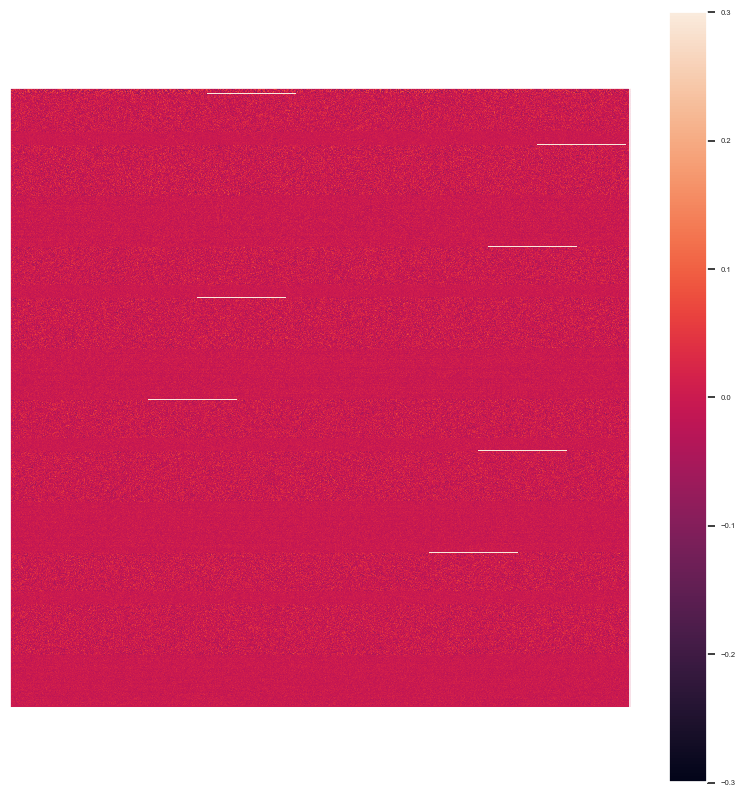

In [51]:
n_params = sum(p.numel() for p in model.parameters())
print(f"total params: {n_params}")

# concatenate all parameters into a single tensor
params = torch.cat([p.data.view(-1) for p in model.parameters()])
print(params.shape)

# make square view of the parameters
n = int(math.ceil(math.sqrt(params.numel())))
params = torch.nn.functional.pad(params, (0, n**2-params.numel()))
params = params.view(n, n)
print(params.shape)

# plot params
plt.figure(figsize=(10, 10))
plt.imshow(
    params.cpu(),
    interpolation='nearest',
    vmax=0.3,
    vmin=-0.3,
)
plt.colorbar()
# no grid
plt.xticks([])
plt.yticks([])
plt.show()

In [67]:
params = torch.cat([p.data.view(-1) for p in model.parameters()])
# indices of parameters > 0.5
indices = torch.nonzero(params > 0.5).squeeze()
# params[params > 0.5].tolist()

l = ((n, p.data.numel(), p.data.mean().item(), p.data.std().item()) for n, p in model.named_parameters())
# sort by mean
l = sorted(l, key=lambda x: x[3], reverse=True)
# print l with padding
for n, numel, mean, std in l:
    print(f"{n[12:]:20s} {numel:10d} {mean:10.4f} {std:10.4f}")
    
# print(f"{l[0][12:]:<30} {l[1]:<10} {l[2]:<10.4f} {l[3]:<10.4f}")
    

wte.weight                 8320     0.0004     0.0382
h.0.mlp.c_fc.weight       65536     0.0000     0.0232
h.0.attn.c_attn.weight      49152    -0.0000     0.0222
h.1.mlp.c_fc.weight       65536    -0.0001     0.0221
h.1.attn.c_attn.weight      49152    -0.0000     0.0215
h.3.attn.c_attn.weight      49152     0.0001     0.0215
h.2.mlp.c_fc.weight       65536    -0.0001     0.0213
h.2.attn.c_attn.weight      49152    -0.0001     0.0213
h.3.mlp.c_fc.weight       65536    -0.0001     0.0211
h.0.mlp.c_proj.weight      65536    -0.0001     0.0125
h.1.mlp.c_proj.weight      65536    -0.0000     0.0109
h.0.ln_1.weight             128     0.9932     0.0103
h.3.attn.c_proj.weight      16384     0.0000     0.0102
h.2.mlp.c_proj.weight      65536     0.0000     0.0100
h.2.attn.c_proj.weight      16384    -0.0000     0.0098
h.3.mlp.c_proj.weight      65536    -0.0000     0.0097
h.1.attn.c_proj.weight      16384     0.0000     0.0095
h.0.attn.c_proj.weight      16384     0.0001     0.0093
h.0.ln_2

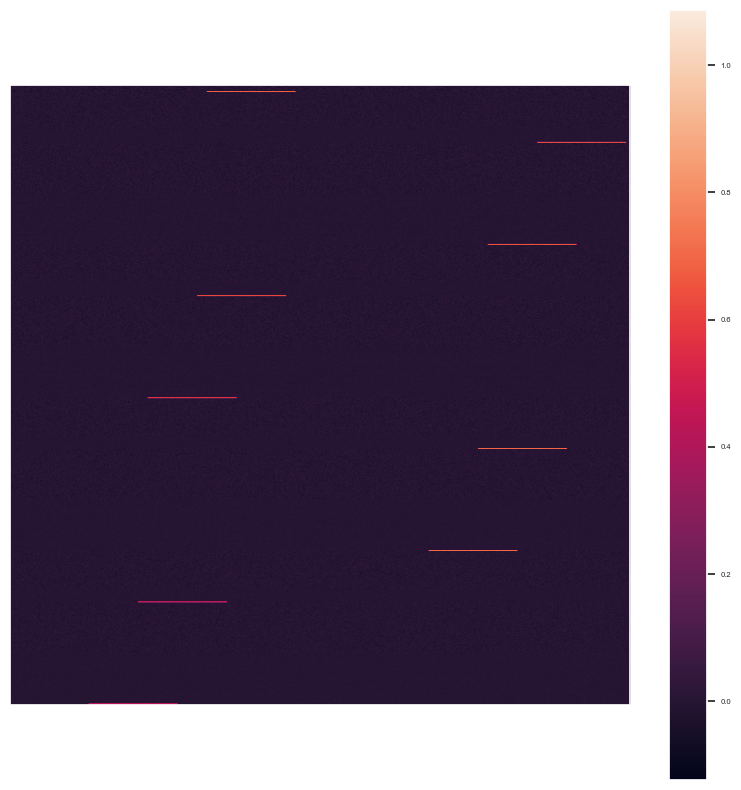

In [71]:
import visualize

visualize.plot_model(model)
# visualize.plot_model_diff(model, model)